## Package Imports: All the necessary packages and modules are imported here.

In [285]:
import torch
import bcolz as bz
import pickle
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import time
import os, sys
import copy
import ast
from PIL import Image
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from PIL import ImageFile
import os 
import pathlib
import os
import glob
import random
from shutil import copyfile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Hyperparameters

In [286]:
batch_size = 64
num_classes = 2
num_features = 2048
learning_rate = 1e-2
num_epochs = 20
weight_decay=0
momentum=0.9

In [287]:
hyperparameters = {
    "batch_size": batch_size,
    "num_classes": num_classes,
    "num_features": num_features,
    "learning_rate": learning_rate,
    "num_epochs": num_epochs,
    "weight_decay": weight_decay,
    "momentum": momentum
}
pickle.dump((hyperparameters,), open('../models/hyperparameters.p', 'wb'))

## Save paths and data sorting

In [390]:

model_weights_path = '../models/catsanddogs/checkpoint.pth.tar'
data_base_path = '../data/raw/catsanddogs'
class_to_idx_path = '../models/catsanddogs/class_to_idx.pkl'
class_names_path = '../models/catsanddogs/class_names.pkl'

In [391]:
%cd ..
current_dir = os.getcwd()
HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/raw/catsanddogs'

/Users/clivecadogan/Documents/workspace/AI/DL/AIPND-Image-Classifier-Application/src


In [392]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [393]:
%cd 'notebooks'

/Users/clivecadogan/Documents/workspace/AI/DL/AIPND-Image-Classifier-Application/src/notebooks


## Training data Agumentation, Normalization and Loading

In [394]:
# Source: http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
#Data Transforms
preprocess = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 406], std=[0.229, 0.224, 0.225])
    ])
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_base_path, x), preprocess[x]) for x in ['train', 'valid', 'test']}
dataLoaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=1) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes
class_to_idx = image_datasets['train'].class_to_idx
use_gpu = torch.cuda.is_available()

In [395]:
print('class_to_index', class_to_index)
print('class_names', class_names)

class_to_index ({'dogs': 1, 'cats': 0},)
class_names ['cats', 'dogs']


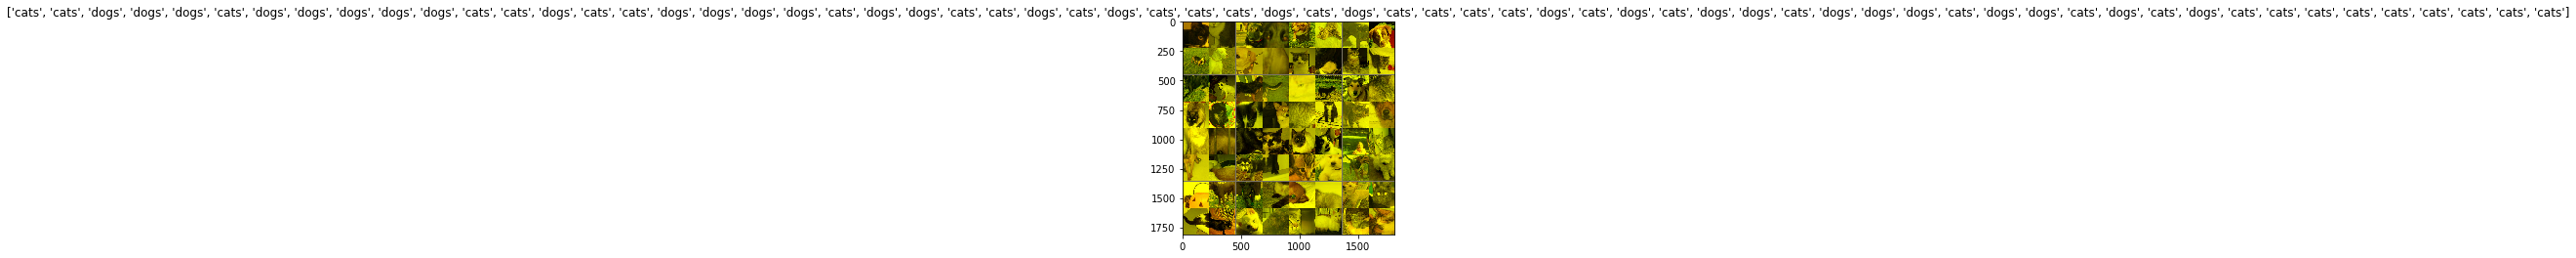

In [290]:
# Source: http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def imshow(inp, title=None):
    """imshow for tensor"""
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

# get a batch of training data
inputs, classes = next(iter(dataLoaders['train']))
#make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Load Pretrained Network, Extract features, Store extracted image features

In [291]:
pretrained_model = models.resnet152(pretrained=True)
modules = list(pretrained_model.children())[:-1]
pretrained_model=nn.Sequential(*modules)
for param in pretrained_model.parameters():
    param.requires_grad = False
if use_gpu:
    pretrained_model = pretrained_model.cuda()

In [292]:
def save_array(filename, arr):
    c=bz.carray(arr, rootdir=filename, mode='w')
    c.flush()

In [293]:
def load_array(filename):
    return bz.open(filename)[:]

In [294]:
#Reference: 
def extract_features(dataset, pretrained_model):
    features = []
    labels_list = []
    for data in dataset:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        x = pretrained_model(inputs)
        features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    features = np.concatenate([[feat] for feat in features])
    return (features, labels_list)

In [295]:
%%time
conv_feat_train, labels_train = extract_features(dataLoaders['train'], pretrained_model)

CPU times: user 3h 34min 40s, sys: 27min 46s, total: 4h 2min 27s
Wall time: 2h 31min 52s


In [297]:
save_array('../data/processed/catsanddogs/conv_feat_train.bc', conv_feat_train)

In [298]:
save_array('../data/processed/catsanddogs/labels_train.bc', labels_train)

In [299]:
%%time
conv_feat_val, labels_val = extract_features(dataLoaders['valid'], pretrained_model)

CPU times: user 18min 46s, sys: 2min 24s, total: 21min 11s
Wall time: 13min 35s


In [300]:
save_array('../data/processed/catsanddogs/conv_feat_val.bc', conv_feat_val)

In [301]:
save_array('../data/processed/catsanddogs/labels_val.bc', labels_val)

In [302]:
%%time
conv_feat_test, labels_test = extract_features(dataLoaders['test'], pretrained_model)

CPU times: user 56.1 s, sys: 7.12 s, total: 1min 3s
Wall time: 43.6 s


In [303]:
save_array('../data/processed/catsanddogs/conv_feat_test.bc', conv_feat_test)

In [304]:
save_array('../data/processed/catsanddogs/labels_test.bc', labels_test)

In [305]:
conv_feat_train = load_array('../data/processed/catsanddogs/conv_feat_train.bc')
labels_train = load_array('../data/processed/catsanddogs/labels_train.bc')
conv_feat_val = load_array('../data/processed/catsanddogs/conv_feat_val.bc')
labels_val = load_array('../data/processed/catsanddogs/labels_val.bc')

In [306]:
conv_feat_test = load_array('../data/processed/catsanddogs/conv_feat_test.bc')
labels_test = load_array('../data/processed/catsanddogs/labels_test.bc')

In [307]:
conv_feat_test.shape

(100, 2048, 1, 1)

In [308]:
conv_feat_train.shape

(23000, 2048, 1, 1)

In [309]:
np.array(labels_train).shape

(23000,)

In [310]:
np.array(conv_feat_val).shape

(2000, 2048, 1, 1)

## Feedforward Classifier

In [311]:
class Classifier(nn.Module):
    """
    """
    def __init__(self, num_features, num_classes):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(num_features, num_classes),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = Classifier(num_features, num_classes)
print(model)

if use_gpu:
    model.cuda()

Classifier(
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=2)
  )
)


## Optimizer

In [312]:
weights, biases = [], []
for name, p in model.named_parameters():
   if 'bias' in name:
       biases += [p]
   else:
       weights += [p]


In [313]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([
  {'params': weights},
  {'params': biases, weight_decay:0}
], lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

## Generator for Convoluted features and labels

In [314]:
def generator(features, labels, batch_size=32, shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(features))
        features = features[index]
        labels = labels[index]
    for i in range(0, len(features), batch_size):
        yield (features[i:i+batch_size], labels[i:i+batch_size])

In [315]:
feature_dataset = {}

## Training Feedforward Classifier

In [316]:
def train(model, dataset_sizes=None, train_features=None, train_labels=None, val_features=None, val_labels=None, criterion=None, optimizer=None, num_epochs=25, train=True, shuffle=None):
    start = time.time()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-'*10)
        train_batches = generator(features=train_features, labels=train_labels, shuffle=shuffle, batch_size=batch_size)
        val_batches = generator(features=val_features, labels=val_labels, shuffle=False, batch_size=batch_size)
        for phase in ['train', 'valid']:
            running_loss = 0.0
            running_corrects = 0
            if phase == 'train':
                model.train()
                for data in train_batches:
                    inputs, labels = data
                    if use_gpu:
                        inputs, labels = Variable(torch.from_numpy(inputs).cuda()), Variable(torch.from_numpy(labels).cuda())
                    else:
                        inputs, labels = Variable(torch.from_numpy(inputs)), Variable(torch.from_numpy(labels))
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    optimizer = optimizer
                    optimizer.zero_grad()
                    _, preds = torch.max(outputs.data, 1)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.data[0] * inputs.size(0)
                    running_corrects += torch.sum(preds==labels.data)
            else:
                model.eval()
                for data in val_batches:
                    inputs, labels = data
                    if use_gpu:
                        inputs, labels = Variable(torch.from_numpy(inputs).cuda()), Variable(torch.from_numpy(labels).cuda())
                    else:
                        inputs, labels = Variable(torch.from_numpy(inputs)), Variable(torch.from_numpy(labels))
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    running_loss += loss.data[0] * inputs.size(0)
                    running_corrects += torch.sum(preds==labels.data)
            
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_accuracy = running_corrects/dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_accuracy))
            
            if phase == 'valid' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = copy.deepcopy(model.state_dict())
        print()
    
    run_time = time.time() - start
    print('Training completed in {:.0f}m and {:.0f}s'.format(run_time//60, run_time%60))
    print('Best Validation Accuracy: {:4f}'.format(best_accuracy))
    model.load_state_dict(best_model_weights)
    return model

In [317]:
model = train(model,dataset_sizes=dataset_sizes, train_features=conv_feat_train, train_labels=labels_train, val_features=conv_feat_val, val_labels=labels_val, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs, train=True, shuffle=True)

Epoch 0/19
----------
train Loss: 0.5270 Acc: 0.7396
valid Loss: 0.4052 Acc: 0.7950

Epoch 1/19
----------
train Loss: 0.5244 Acc: 0.7602
valid Loss: 0.3513 Acc: 0.8325

Epoch 2/19
----------
train Loss: 0.5025 Acc: 0.7680
valid Loss: 0.4596 Acc: 0.7835

Epoch 3/19
----------
train Loss: 0.4860 Acc: 0.7736
valid Loss: 0.6345 Acc: 0.7230

Epoch 4/19
----------
train Loss: 0.4842 Acc: 0.7781
valid Loss: 0.3437 Acc: 0.8450

Epoch 5/19
----------
train Loss: 0.4684 Acc: 0.7804
valid Loss: 0.6059 Acc: 0.7350

Epoch 6/19
----------
train Loss: 0.4657 Acc: 0.7835
valid Loss: 0.5626 Acc: 0.7470

Epoch 7/19
----------
train Loss: 0.4597 Acc: 0.7839
valid Loss: 0.3421 Acc: 0.8390

Epoch 8/19
----------
train Loss: 0.4413 Acc: 0.7950
valid Loss: 0.3300 Acc: 0.8405

Epoch 9/19
----------
train Loss: 0.4389 Acc: 0.7955
valid Loss: 0.3349 Acc: 0.8420

Epoch 10/19
----------
train Loss: 0.5103 Acc: 0.7773
valid Loss: 0.3327 Acc: 0.8470

Epoch 11/19
----------
train Loss: 0.4333 Acc: 0.7977
valid Loss

## Saving checkpoint

In [318]:
model_weights_path

'../models/catsanddogs/checkpoint.pth.tar'

In [319]:
# Saving The Model:
torch.save(model.state_dict(), model_weights_path)

In [320]:
hyperparameters_loaded = pickle.load(open('../models/hyperparameters.p', mode='rb'))
print('hyperparameters_loaded', hyperparameters_loaded)

hyperparameters_loaded ({'learning_rate': 0.01, 'num_features': 2048, 'num_classes': 2, 'num_epochs': 20, 'weight_decay': 0, 'momentum': 0.9, 'batch_size': 64},)


In [396]:
pickle.dump((class_to_idx,), open(class_to_idx_path, 'wb'))
pickle.dump((class_names,), open(class_names_path, 'wb'))

## Test Accuracy

In [322]:
def test_accuracy(model, dataset_size=27, conv_feat_test=None, labels_test=None, criterion=None,num_epochs=1, shuffle=None):
    start = time.time()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-'*10)
        val_batches = generator(features=conv_feat_test, labels=labels_test, shuffle=False, batch_size=batch_size)
        running_loss = 0.0
        running_corrects = 0
        model.eval()
        for data in val_batches:
            inputs, labels = data
            if use_gpu:
                inputs, labels = Variable(torch.from_numpy(inputs).cuda()), Variable(torch.from_numpy(labels).cuda())
            else:
                inputs, labels = Variable(torch.from_numpy(inputs)), Variable(torch.from_numpy(labels))
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.data[0] * inputs.size(0)
            running_corrects += torch.sum(preds==labels.data)

        epoch_loss = running_loss/dataset_size
        epoch_accuracy = running_corrects/dataset_size
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('Testing:', epoch_loss, epoch_accuracy))

        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            best_model_weights = copy.deepcopy(model.state_dict())
        print()
    
    run_time = time.time() - start
    print('Testing completed in {:.0f}m and {:.0f}s'.format(run_time//60, run_time%60))
    print('Best Test Accuracy: {:4f}'.format(best_accuracy))
    model.load_state_dict(best_model_weights)
    return model
test_accuracy(model, dataset_size=100, conv_feat_test=conv_feat_test, labels_test=labels_test, criterion=criterion,num_epochs=1, shuffle=None)

Epoch 0/0
----------
Testing: Loss: 0.1760 Acc: 0.9200

Testing completed in 0m and 0s
Best Test Accuracy: 0.920000


Classifier(
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=2)
  )
)

## Sanity Checking with matplotlib

In [387]:
# Source: http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def sanity_checking_model(model, pretrained_model,num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    for i, data in enumerate(dataLoaders['test']):
        inputs, labels = data
        print('inputs.shape', inputs.shape)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        extracted_inputs = pretrained_model(inputs)
        outputs = model(extracted_inputs)
        _, preds = torch.max(outputs.data, 1)
        _, predictedTop5_test = outputs.topk(2)
        probs = torch.nn.functional.softmax(outputs)
        probs = probs.data.numpy()
        for k in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('Predicted: {} Prob: {:.2%}'.format(class_names[preds[k]], probs[k][preds[k]]))
            imshow(inputs.cpu().data[k])
            if images_so_far == num_images:
                return

### Loading Checkpoint

In [388]:
state = torch.load(model_weights_path)
model = Classifier(num_features, num_classes)
model.load_state_dict(state)

inputs.shape torch.Size([64, 3, 224, 224])


/Applications/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


predictedTop5_test[0] Variable containing:
 1
 0
[torch.LongTensor of size 2]

probs[0]  [  6.60018646e-04   9.99339998e-01]
preds[0] 1


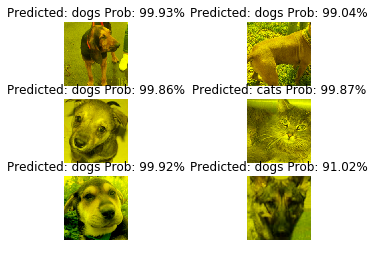

In [389]:
sanity_checking_model(model, pretrained_model, num_images=6)